In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
def generate_2d_data(batch_size=1000):
    rng = np.random.RandomState()
        
    scale = 4.
    centers = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    centers = [(scale * x, scale * y) for x, y in centers]

    dataset = []
    for i in range(batch_size):
        point = rng.randn(2) * 0.5   #According to me, 0.5 should not be there.
        idx = rng.randint(4)
        center = centers[idx]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
    dataset = np.array(dataset, dtype="float32")
    dataset /= 1.414                #According to me, this line should not be there.
    return dataset

In [ ]:
def plot_samples_2d(data, name=None):
    plt.figure(figsize=(5,5))
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    plt.scatter(data[:, 0], data[:, 1]) 
    
    if name:
        plt.savefig('./demo/%s'%(name) + ".png", format="png")

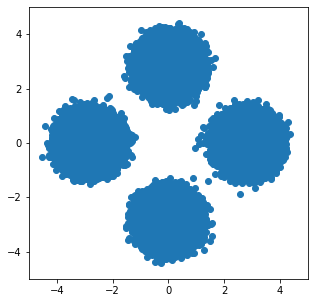

In [ ]:
data=generate_2d_data(1000000)
plot_samples_2d(data)

**Note:** We just have the samples, no $p^*_x(x)$.

Let us create the input distribution $p_u(u)$

In [ ]:
import tensorflow_probability as tfp
from tensorflow import sigmoid, tanh

base_dist = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros([2])) #, tf.float32))

In [ ]:
def sigmoid_grad(x):
  return sigmoid(x)*(1-sigmoid(x))
def tanh_grad(x):
  return 1-tanh(x)**2

In [ ]:
class PlanarFlow:
  def __init__(self, input_shape, h_func):
      self.input_shape = input_shape
      self.h_func = h_func
      self.w = tf.Variable(tf.random.normal([input_shape]),trainable=True)
      self.b = tf.Variable(tf.zeros(1),trainable=True)
      self.c = tf.Variable(tf.random.normal([input_shape]),trainable=True)
  
  def forward(self,u):
    t1 = tf.reduce_sum(tf.multiply(self.w,u),1)+self.b
    t1_ = tf.repeat(tf.expand_dims(t1,axis=1),repeats=self.input_shape,axis=1)
    
    if self.h_func=="sigmoid":      
      t2 = self.c*sigmoid(t1_)
      t3 = tf.reduce_sum(tf.multiply(self.c,self.w))
      det_J = 1+sigmoid_grad(t1)*t3

    elif self.h_func=="tanh":
      t2 = self.c*tanh(t1_)
      t3 = tf.reduce_sum(tf.multiply(self.c,self.w))
      det_J = 1+tanh_grad(t1)*t3
    
    x = u + t2  
    forward_log_det_J = tf.math.log(abs(det_J))

    return x, forward_log_det_J

In [ ]:
n = 4
pfl_chain = []
for i in range(n): 
    func = "sigmoid"
    pfl_chain.append(PlanarFlow(2,func))

In [ ]:
def final_forward(u):
  x = u
  total_log_det_J_fwd = 0
  for i in range(n):
    x, fwd_logdet_J = pfl_chain[i].forward(x)
    total_log_det_J_inv = total_log_det_J_fwd + fwd_logdet_J
  return x, total_log_det_J_fwd

In [ ]:
@tf.function
def train_planar_flow(data_batch, planar_flow_model, base_dist, optimizer):
  with tf.GradientTape() as tape:
    u, total_log_det_J_inv = final_forward(data_batch)
    loss = -tf.reduce_mean(base_dist.log_prob(u) + total_log_det_J_inv)  #computes mean and reduces it

  gradients = tape.gradient(loss, tape.watched_variables())
  optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
  # print(tape.watched_variables())
  return loss

In [ ]:
dataset_size = 1000000
epochs = 1
optimizer = optimizers.Adam(learning_rate = 0.001)
batch_size = 128
batches_per_epoch = dataset_size//batch_size+1
loss = []
for i in range(epochs):
  for j in range(batches_per_epoch):
    data_batch = data[batch_size*j:batch_size*(j+1)]
    last_loss = train_planar_flow(data_batch, pfl_chain, base_dist, optimizer)
    loss.append(last_loss)
    print(last_loss)

Streaming output truncated to the last 5000 lines.
tf.Tensor(1.9076028, shape=(), dtype=float32)
tf.Tensor(1.9089665, shape=(), dtype=float32)
tf.Tensor(1.9073617, shape=(), dtype=float32)
tf.Tensor(1.8907398, shape=(), dtype=float32)
tf.Tensor(1.8927486, shape=(), dtype=float32)
tf.Tensor(1.8984586, shape=(), dtype=float32)
tf.Tensor(1.9052882, shape=(), dtype=float32)
tf.Tensor(1.9072477, shape=(), dtype=float32)
tf.Tensor(1.9069178, shape=(), dtype=float32)
tf.Tensor(1.8978425, shape=(), dtype=float32)
tf.Tensor(1.9126847, shape=(), dtype=float32)
tf.Tensor(1.8884877, shape=(), dtype=float32)
tf.Tensor(1.9155772, shape=(), dtype=float32)
tf.Tensor(1.8963144, shape=(), dtype=float32)
tf.Tensor(1.9078087, shape=(), dtype=float32)
tf.Tensor(1.8895906, shape=(), dtype=float32)
tf.Tensor(1.9117458, shape=(), dtype=float32)
tf.Tensor(1.8972485, shape=(), dtype=float32)
tf.Tensor(1.8923025, shape=(), dtype=float32)
tf.Tensor(1.9046879, shape=(), dtype=float32)
tf.Tensor(1.8950548, shape=()

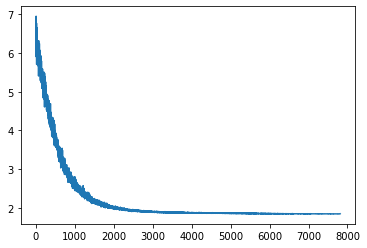

In [ ]:
plt.plot(loss)

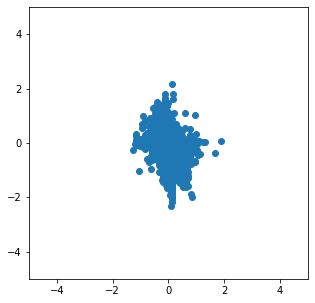

In [ ]:
test_samples_u = base_dist.sample(10000000)
test_samples_x, _ = final_forward(test_samples_u)
plot_samples_2d(test_samples_x)